<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/06-model-evaluation/QualityMetrics_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [321]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [322]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [323]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.9400000000000001


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

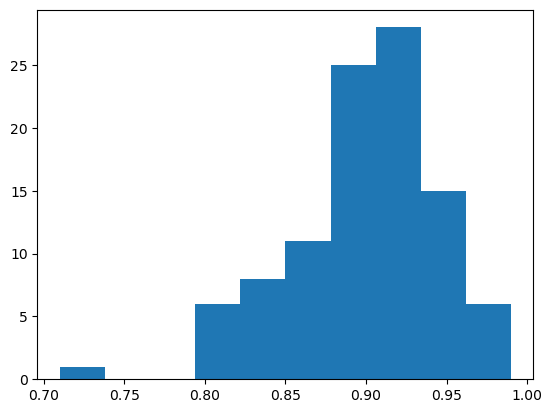

In [324]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

I guess, main problem is connected with the fact that further we take only features that have best covariation with the target, so these features are enough to make pretty good predictions, so if we use all the features, we have to receive accuracy about .5:

So, let's make experiment with features_selector and without it

Text(0.5, 1.0, 'A lot of features, num of selected features < all features')

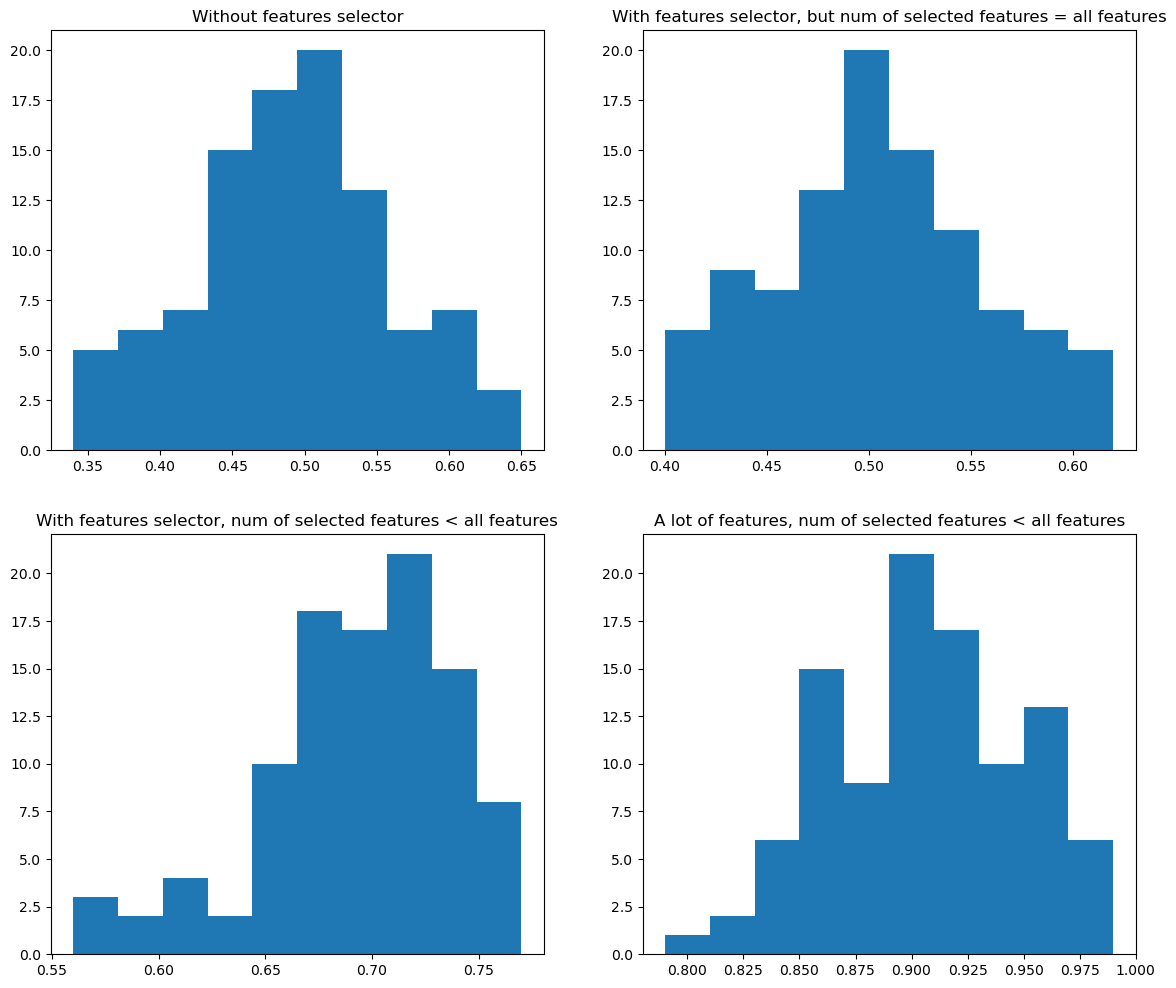

In [325]:
def experiment_full_data(features_selector:bool=False, num_features_best:int=100, X_num_features:int=1000):
  # Dataset generation
  X = np.random.normal(size=(N, X_num_features)) # we can use each number of features
  y = np.random.randint(2, size=N)

  if features_selector:
  # Feature selection: 
    X_best = FeatureSelector(num_features_best).fit_transform(X, y)
  else:
    X_best = X

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results1 = [experiment_full_data() for _ in range(100)] #wo features selection -> should have about .5 accuracy score
results2 = [experiment_full_data(True, 100,100) for _ in range(100)] #with features selection but num of best features = num of all features -> should have about .5 accuracy score
results3 = [experiment_full_data(True, 10, 100) for _ in range(100)] #with features selection but num of best features < num of all features -> should have score more than random
results4 = [experiment_full_data(True, 100, 1000) for _ in range(100)] #with features selection but num of best features < num of all features -> should have close to 1 accuracy score
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(14,12))
ax1.hist(results1, bins=10)
ax2.hist(results2, bins=10)
ax3.hist(results3, bins=10)
ax4.hist(results4, bins=10)
ax1.set_title('Without features selector')
ax2.set_title('With features selector, but num of selected features = all features') #this plot just to check whether we features selector doesn't work on equal number of features, it is logical, that it doesn't work because we have random generated_features
ax3.set_title('With features selector, num of selected features < all features') #just to prove that we can take some features from random generated that have good enough covariance with random generated target to make good predictions
ax4.set_title('A lot of features, num of selected features < all features') #just to prove that we can take some features from random generated that have good enough covariance with random generated target to make good predictions, and the more features we have, the better result we receive generaly


So, now we received accuracy that is supposed to be as we was waited for.

We can formulate a conclusion, that even in randomly generated data we can receive good score of our model just picking most correlated features with target, in logic that the more features we have by default, the better features we can pick from them to receive better score.

## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook). 

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
``` 

In [326]:
# !wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

In [327]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler

data = pd.read_csv("train.csv", index_col='PassengerId')

In [328]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In previous homework I received .76 accuracy score, let's try to improve it 

In [332]:
# Creating class just for practicing OOP:)
class predictions():

    def __init__(self, model, hyperparameters:dict = {'n_neighbors':30}):
        self.model = model
        self.hyperparameters = hyperparameters

    def features_transformation(self, dataset):
        self.dataset = dataset
        df = self.dataset.copy()
        self.y = df['Survived'] 
        self.X = df.drop('Survived', axis=1)

        # fillna
        numerical_features = self.X.select_dtypes(exclude=['object']).columns
        self.X[numerical_features] = self.X[numerical_features].fillna(self.X[numerical_features].mode().iloc[0])
    
        # Fill missing values in categorical columns
        categorical_features = self.X.select_dtypes(include=['object']).columns
        self.X[categorical_features] = self.X[categorical_features].fillna(self.X[categorical_features].mode().iloc[0])
            
        # transform features a bit
        self.X['Age'] = pd.cut(self.X.Age, 3, labels=['young', 'midage', 'old'])
        self.X['Fare'] = self.X['Fare'].apply(lambda fare: fare if fare != 0 else self.X['Fare'].median())
        self.X['Sex'] = self.X['Sex'].apply(lambda sex: 1 if sex=='female' else 2)

        self.columns = ['Age', 'Fare', 'Sex', 'Pclass', 'Parch']
        return self.X[self.columns], self.y
        
        

    def fit(self, dataset):
        X, y = self.features_transformation(dataset) 
        knn = self.model(**self.hyperparameters)
        label_encoder = LabelEncoder()
        X['Age'] = label_encoder.fit_transform(X['Age'])
        model = make_pipeline(
        
    
        make_column_transformer(
            (MinMaxScaler(),  ['Pclass', 'Fare']),
            (OneHotEncoder(sparse=False), ['Sex']),
            remainder='passthrough',
            
        ),
        knn
        )

        return cross_val_score(model, X, y, scoring='accuracy', cv=5, n_jobs=-1).mean()
       

    
     

In [331]:
params = {
    'n_neighbors':27,
    'weights' : 'distance',
    'algorithm' : 'brute'
          }
model = predictions(KNeighborsClassifier, params)
model.features_transformation(data)
model.fit(data)

/var/folders/pd/fjb9sj5x6t3dnxtpzxxzkv6c0000gn/T/ipykernel_46448/4244532204.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Age'] = label_encoder.fit_transform(X['Age'])


0.8148201619484026

That way we improved our KNN model to .81 accuracy_score